## Train an RL agent controlling different sources
This notebook will focus the following topics:

 - define an experiment one RL agent controlling different sources,
 - how to use the names of a named policy to hand different rewards to different agents,
 - learn how the `MultiController hands the correct indices to the corresponding controllers,
 - training an RL agent for a task in an electric grid formed by a classic controller.

In this notebook a reinforcement learning agent is trained control 3 sources at oncelike shown in the figure below.
The electrical power grid is here abstracted similar to the output of the `DrawGraph(env.nc)` methode.
The sources and loads (here no loads are availabe) shown as colored circles connected via cables.
This is similar like the usage of the GUI, where the sources, loads and cables can be parameterized and connected interactivly.

![](figures/RL_Complex_Demo.png "")


In [27]:
using JEG
using ReinforcementLearning

In [28]:
CM = [0.0   1.0  0
     -1.0   0.0  2.0
     0  -2.0  0.0]

parameters =
Dict{Any, Any}(
    "source" => Any[
                    Dict{Any, Any}(
                        "pwr" => 200e3,
                        "control_type" => "RL",
                        "mode" => "my_ddpg",
                        "fltr" => "L"),
                    Dict{Any, Any}(
                        "pwr" => 200e3,
                        "fltr" => "LC",
                        "control_type" =>
                        "RL", "mode" => "my_ddpg"),
                    Dict{Any, Any}(
                        "pwr" => 200e3,
                        "fltr" => "L",
                        "control_type" =>
                        "RL", "mode" => "my_ddpg"),
                    ],
    "grid" => Dict{Any, Any}(
        "phase" => 1,
        "ramp_end" => 0.04,)
)


Dict{Any, Any} with 2 entries:
  "source" => Any[Dict{Any, Any}("control_type"=>"RL", "mode"=>"my_ddpg", "fltr…
  "grid"   => Dict{Any, Any}("phase"=>1, "ramp_end"=>0.04)

It can be noticed, that the control `mode` for all three sources is set to the same `my_ddpg` agent.


As `reference(t)` function for simlicity, DC-values are used, one per source, since we are dealing with a single phase grid:

In [29]:
function reference(t)
    return [-10, 230, -15]
end

reference (generic function with 1 method)

Afterwards the `featurize()` function adds the signal generated by the `reference` function to the state for the agent `my_ddpg`:

In [30]:
featurize_ddpg = function(state, env, name)
    if name == "my_ddpg"
        norm_ref = env.nc.parameters["source"][1]["i_limit"]
        state = vcat(state, reference(env.t)/norm_ref)
    end
end

#25 (generic function with 1 method)

Then the `reward()` function is defined. Here, again it is based on the root-mean square error (RMSE) teach the agent `my_ddpg` to match the reference signal to the measured signal. 

If the measured state is greater than `1`. In that case a punishment is returned which, here, is chosen to be `r = -1`.
It not and if the measured value differs from the reference, the average error is substracted from the maximal reward: `r = 1 - RMSE`:

$r = 1 - \frac{1}{3} \sum_{{p \in \{\mathrm{a,b,c}\}}} \sqrt{\frac{|x_\mathrm{ref,p} - x_\mathrm{meas,p}|}{2}}$

__Important here is the choise of the states!__

For the first and third source the current thougth the inductors are used. 
Since the `reference` value is negative, the agent should learn to draw current from the grid.
For the secound source, the voltag accros the capacitor is used and the reference value is positive. 
Therefore, the agent should learn to supply the capacitor / "build up a grid" (while the other 2 sources draw current!).

In [31]:
function reward_function(env, name = nothing)
    if name == "my_ddpg"
        state_to_control_1 = env.state[findfirst(x -> x == "source1_i_L1", env.state_ids)]
        state_to_control_2 = env.state[findfirst(x -> x == "source2_v_C_filt", env.state_ids)]
        state_to_control_3 = env.state[findfirst(x -> x == "source3_i_L1", env.state_ids)]


        state_to_control = [state_to_control_1, state_to_control_2, state_to_control_3]

        if any(abs.(state_to_control).>1)
            return -1
        else

            refs = reference(env.t)
            norm_ref = env.nc.parameters["source"][1]["i_limit"]    
            # TODO: norm for v different!      
            r = 1-1/3*(sum((abs.(refs/norm_ref - state_to_control)/2).^0.5))
            return r 
        end
    else
        return 1
    end

end

reward_function (generic function with 2 methods)

Then, the defined parameters, featurize and reward functions are used to create an environment consisting of the electircal power grid:

In [32]:
env = ElectricGridEnv(
    CM = CM,
    parameters = parameters, 
    t_end = 0.1, 
    featurize = featurize_ddpg, 
    reward_function = reward_function, 
    action_delay = 0);

Like already shon in `RL_Single_Agent_DEMO.ipynb`, again an DDPG agent is created. 
The `SetupAgents()` function is then used to configure the `controllers` utilizing the `MultiController`.

In [33]:
agent = CreateAgentDdpg(na = length(env.agent_dict["my_ddpg"]["action_ids"]),
                          ns = length(state(env, "my_ddpg")),
                          use_gpu = false)

my_custom_agents = Dict("my_ddpg" => agent)

controllers = SetupAgents(env, my_custom_agents)

typename(MultiController)
├─ agents => typename(Dict)
├─ action_ids => 3-element Vector{Any}
└─ hook => typename(DataHook)
   ├─ save_data_to_hd => false
   ├─ dir => "episode_data/"
   ├─ A => typename(Nothing)
   ├─ B => typename(Nothing)
   ├─ collect_state_paras => typename(Nothing)
   ├─ extra_state_paras => 0-element Vector{Any}
   ├─ extra_state_ids => 0-element Vector{Any}
   ├─ extra_state_names => 0-element Vector{Any}
   ├─ collect_sources => 0-element Vector{Any}
   ├─ collect_cables => 0-element Vector{Any}
   ├─ collect_loads => 0-element Vector{Any}
   ├─ collect_state_ids => 0-element Vector{Any}
   ├─ collect_next_state_ids => 0-element Vector{Any}
   ├─ collect_action_ids => 0-element Vector{Any}
   ├─ df => typename(DataFrames.DataFrame)
   │  ├─ columns => 0-element Vector{AbstractVector}
   │  └─ colindex => typename(DataFrames.Index)
   │     ├─ lookup => typename(Dict)
   │     └─ names => 0-element Vector{Symbol}
   ├─ tmp => typename(DataFrames.DataFrame)
   │ 

Here, the `controllers` struct constits only of the one `my_ddpg` agent:

In [34]:
controllers.agents

Dict{Any, Any} with 1 entry:
  "my_ddpg" => Dict{Any, Any}("policy"=>typename(Agent)…

This agent puts out three different actions, one per source:

In [35]:
controllers.agents["my_ddpg"]["action_ids"]

3-element Vector{Any}:
 "source1_u"
 "source2_u"
 "source3_u"

And has knowlegde about all the states of the three sources:

In [36]:
controllers.agents["my_ddpg"]["state_ids"]

7-element Vector{Any}:
 "source1_i_L1"
 "source1_v_C_cables"
 "source2_i_L1"
 "source2_v_C_filt"
 "source2_v_C_cables"
 "source3_i_L1"
 "source3_v_C_cables"

The next steps are straigth forward compared to the prior RL example notebooks like `RL_Classical_Controllers_Merge_DEMO.ipynb`

In [37]:
Learn(controllers, env, num_episodes = 20)

                 ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀        
                 ┌────────────────────────────────────────┐        
         284.183 │⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ my_ddpg
                 │⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠸⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
   Score         │⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⢱⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

DataHook(false, "episode_data/", [-199.99999999999997 -2927.9783900064085 … 0.0 0.0; 5000.0 0.0 … -5000.0 0.0; … ; 0.0 4000.0 … -832.0 0.0; 0.0 0.0 … 0.0 -832.0], [2927.9783900064085 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], Any[0.0003415325753131024, 0.0002, 0.0003415325753131024, 0.00015412304086843381, 0.0004, 0.0003415325753131024, 0.0002, 0.00025, 0.00025], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], 919×5 DataFrame
 Row │ episode  time     action                             reward  done  
     │ Int64    Float32  Array…                             Int64   Bool  
─────┼────────────────────────────────────────────────────────────────────
   1 │       1   0.0     Union{Nothing, Float64}[0.014860…       1  false
   2 │       1   0.0001  Union{Nothing, Float64}[-0.00355…       1  false
   3 │       1   0.0002  Union{Nothing, Float64}[0.028074…       1  false
   4 │       1   0.0003  Union{Nothing, Float64}[-5.70327…       1  false
   5 │       1   0.0004 

After the training, the `Simulate()` function is used to run a test epiode without action noise and the state to be controlled ($i_\mathrm{L1}$) is plotted:

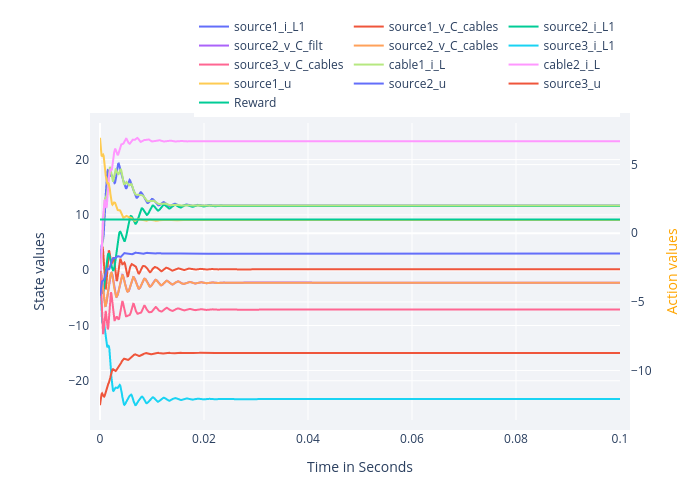

In [38]:
hook = DataHook(collect_state_ids = env.state_ids,
                collect_action_ids = env.action_ids)

hook = Simulate(controllers, env, hook=hook)


RenderHookResults(hook = hook,
                    states_to_plot  = env.state_ids,
                    actions_to_plot = env.action_ids,
                    plot_reward=true)
